#### BARRY ALPHA & VIANNEY GRIMAUD

In [27]:
import pandas as pd
import time

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.ticker import AutoMinorLocator

In [3]:
from river import (
    datasets,
    ensemble,
    evaluate,
    linear_model,
    metrics,
    multiclass,
    naive_bayes,
    neighbors,
    optim,
    preprocessing,
    stream,
    tree,
    utils,
)

from river.stream import iter_pandas

In [4]:
import warnings
#warnings.filterwarnings("ignore")

In [6]:
# Load the data, will be transformed into a stream later
df = pd.read_csv("covtype.data")
label_col = df.columns[-1]
feature_cols = list(df.columns)
feature_cols.pop()
X = df[feature_cols]
Y = df[label_col]

# Methods

## Logistic Regression

It is a statistical model used for classification and predictive analytics that estimates the probability of an event occurring based on a given dataset of independent variables

In [7]:
logistic_model = linear_model.LogisticRegression(
    optimizer=optim.SGD(lr=0.1),  # Stochastic Gradient Descent optimizer
    loss=optim.losses.Log(),  # Log loss function for logistic regression
    l2=0.001,  # L2 regularization strength
)

## ADWIN Bagging Classifier

It is an online bagging method with the addition of the ADWIN algorithm as a change detector. If concept drift is detected, the worst member of the ensemble is replaced by a new classifier.

In [8]:
adwin_model = ensemble.ADWINBaggingClassifier(
    model=(
        preprocessing.StandardScaler() |
        linear_model.LogisticRegression()
    ),
    n_models=3,
    seed=42
)


## Voting Classifier

 It is an ensemble technique where multiple base classifiers are used to predict the class labels of unseen data. The final prediction is made by taking a majority vote or an average of the predictions from the base classifiers.

In [9]:
voting_model = (
    preprocessing.StandardScaler() |
    ensemble.VotingClassifier([
        linear_model.LogisticRegression(),
        tree.HoeffdingTreeClassifier(),
        naive_bayes.GaussianNB()
    ])
)

## Bagging Classifier

It is an ensemble meta-estimator that fits base classifiers each on random subsets of the original dataset and then aggregates their individual predictions to form a final prediction.

In [10]:
bagging_model = ensemble.BaggingClassifier(
    model=(
        preprocessing.StandardScaler() |
        linear_model.LogisticRegression()
    ),
    n_models=3,
    seed=42
)

## AdaBoost Classifier

It is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases.

In [11]:
adaboost_model = ensemble.AdaBoostClassifier(
    model=(
        tree.HoeffdingTreeClassifier(
            split_criterion='gini',
            delta=1e-5,
            grace_period=2000
        )
    ),
    n_models=5,
    seed=42
)

## KNN Classifier

It is a data classification algorithm that attempts to determine what group a data point is in by looking at the data points around it.

In [12]:
knn_model = neighbors.KNNClassifier(n_neighbors=5)

Optimiser? OUI

With Manhattan distance instead of Euclidean one?

## Hoeffding Tree Classifier

It is an incremental, anytime decision tree induction algorithm that is capable of learning from massive data streams, assuming that the distribution generating examples does not change over time.

In [14]:
hoeffding_model = tree.HoeffdingTreeClassifier()

# Comparison and Interpretation

In [15]:
models=[logistic_model, adwin_model, voting_model, bagging_model, adaboost_model, knn_model, hoeffding_model]

In [16]:
from river import metrics, utils

def print_progress(sample_id, acc, kappa, f1, weighted_f1, balanced_acc, roc_auc):
    print(f'Samples processed: {sample_id}')
    print(acc)
    print(kappa)
    print(f1)
    print(weighted_f1)
    print(balanced_acc)

def evaluate(stream, model, n_wait=10000, verbose=False):
    acc = metrics.Accuracy()
    acc_rolling = utils.Rolling(metrics.Accuracy(), window_size=n_wait)
    kappa = metrics.CohenKappa()
    kappa_rolling = utils.Rolling(metrics.CohenKappa(), window_size=n_wait)

    # Add new metrics
    f1 = metrics.F1()
    f1_rolling = utils.Rolling(metrics.F1(), window_size=n_wait)
    weighted_f1 = metrics.WeightedF1()
    weighted_f1_rolling = utils.Rolling(metrics.WeightedF1(), window_size=n_wait)
    balanced_acc = metrics.BalancedAccuracy()
    balanced_acc_rolling = utils.Rolling(metrics.BalancedAccuracy(), window_size=n_wait)

    raw_results = []
    model_name = model.__class__.__name__

    for i, (x_dict, y) in enumerate(stream):  # Ensure x is a dictionary
        # Predict
        y_pred = model.predict_one(x_dict)

        # Only update metrics if prediction is not None
        if y_pred is not None:
            # Update metrics and results
            acc.update(y_true=y, y_pred=y_pred)
            acc_rolling.update(y_true=y, y_pred=y_pred)
            kappa.update(y_true=y, y_pred=y_pred)
            kappa_rolling.update(y_true=y, y_pred=y_pred)

            # Update new metrics
            f1.update(y_true=y, y_pred=y_pred)
            f1_rolling.update(y_true=y, y_pred=y_pred)
            weighted_f1.update(y_true=y, y_pred=y_pred)
            weighted_f1_rolling.update(y_true=y, y_pred=y_pred)
            balanced_acc.update(y_true=y, y_pred=y_pred)
            balanced_acc_rolling.update(y_true=y, y_pred=y_pred)

        if i % n_wait == 0 and i > 0:
            if verbose:
                print_progress(i,
                               acc.get(),
                               kappa.get(),
                               f1.get(),
                               weighted_f1.get(),
                               balanced_acc.get(),
                               roc_auc.get())

            raw_results.append([model_name,
                                i,
                                acc.get(),
                                acc_rolling.get(),
                                kappa.get(),
                                kappa_rolling.get(),
                                f1.get(),
                                f1_rolling.get(),
                                weighted_f1.get(),
                                weighted_f1_rolling.get(),
                                balanced_acc.get(),
                                balanced_acc_rolling.get()])

        # Learn (train)
        model.learn_one(x_dict, y)

    if verbose:
        print_progress(i+1,
                       acc.get(),
                       kappa.get(),
                       f1.get(),
                       weighted_f1.get(),
                       balanced_acc.get(),
                       roc_auc.get())

    return pd.DataFrame(raw_results,
                        columns=['Model',
                                 'id',
                                 'Accuracy',
                                 'acc_roll',
                                 'Kappa',
                                 'kappa_roll',
                                 'F1',
                                 'f1_roll',
                                 'Weighted F1',
                                 'weighted_f1_roll',
                                 'Balanced Accuracy',
                                 'balanced_acc_roll'])


In [17]:
results = [evaluate(stream=iter_pandas(X,Y), model=m) for m in models]

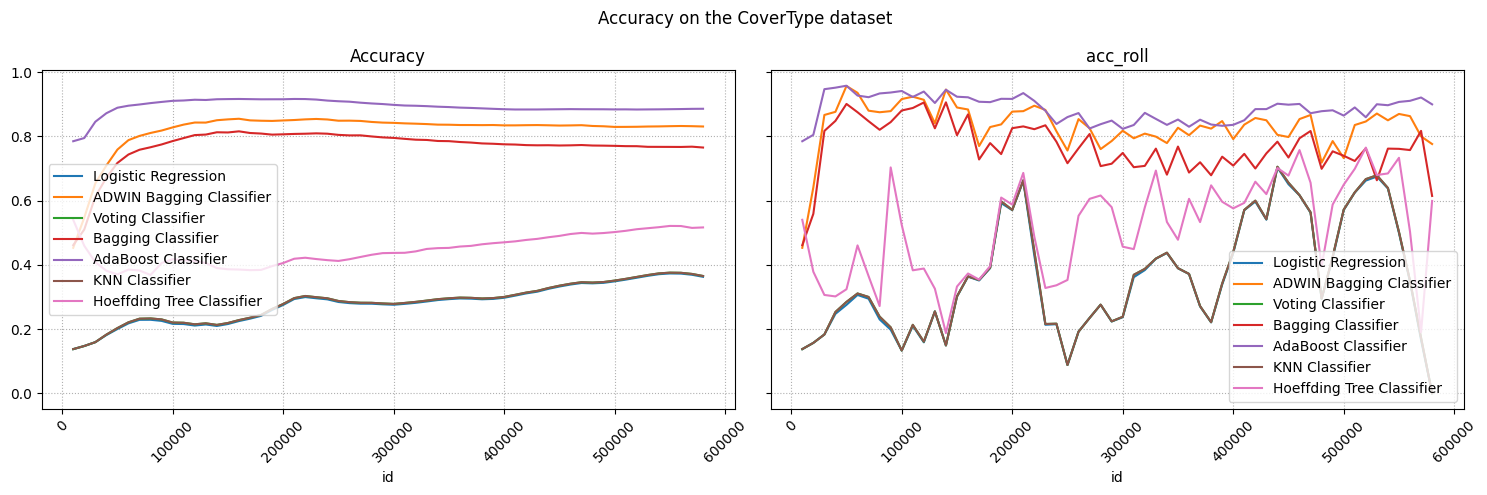

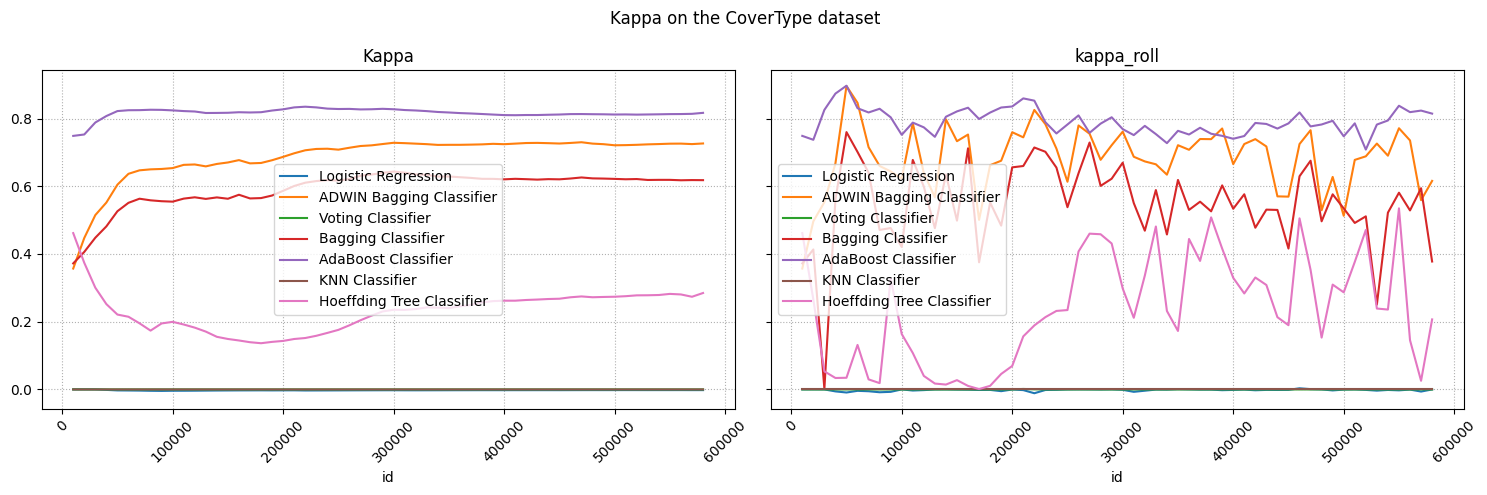

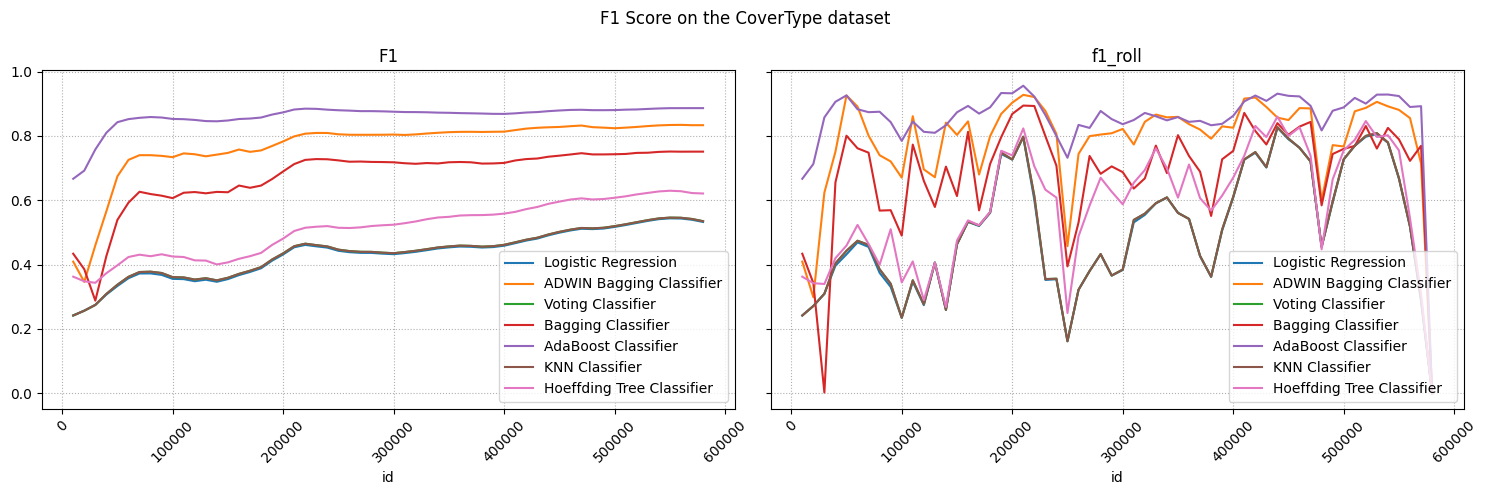

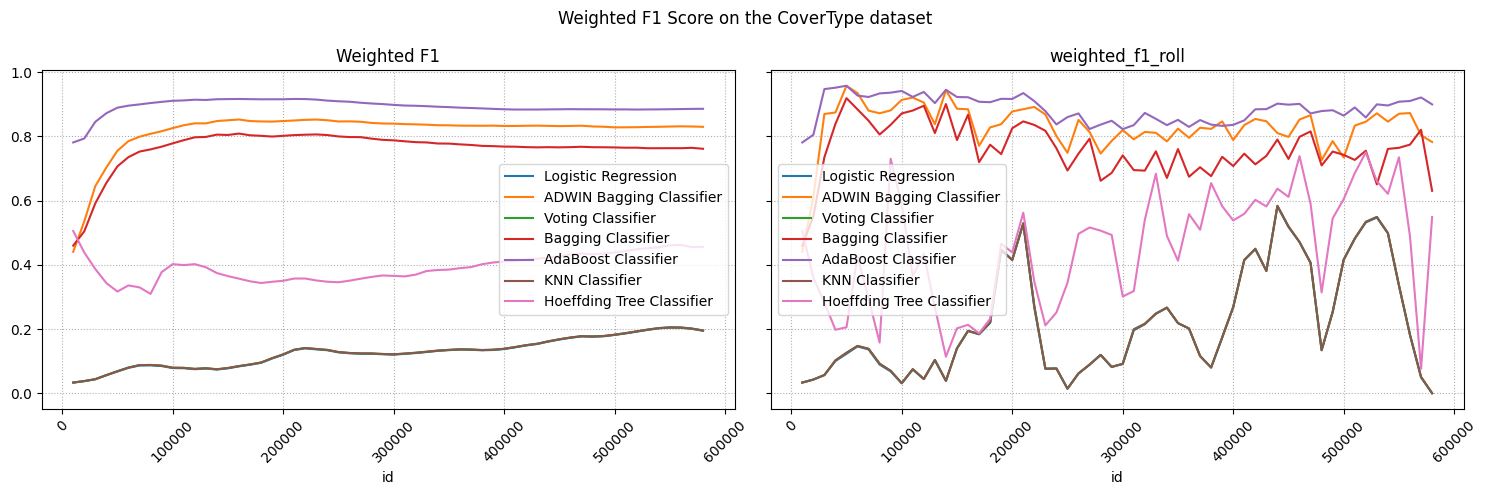

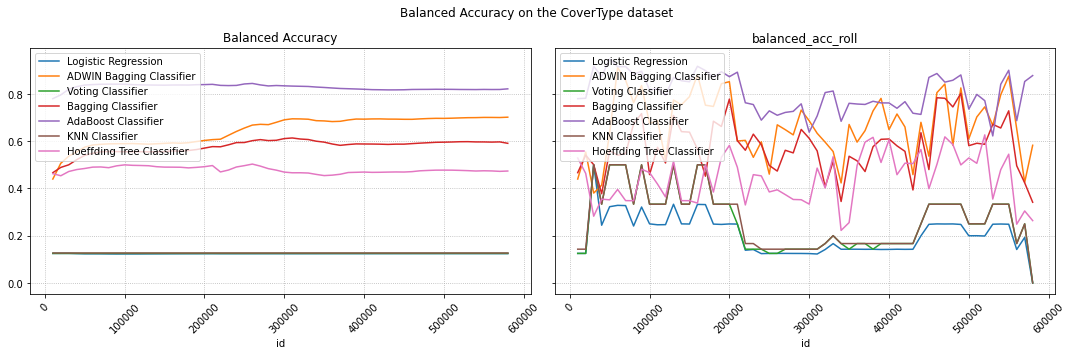

In [26]:
dataset = "CoverType"

df = pd.concat(results)
legend = ["Logistic Regression", "ADWIN Bagging Classifier", "Voting Classifier", "Bagging Classifier", "AdaBoost Classifier", "KNN Classifier", "Hoeffding Tree Classifier"]
df.set_index('id', inplace=True)
grouped = df.groupby('Model')

with PdfPages(f'results_{dataset}.pdf') as pdf:
    # Plot Accuracy and Rolling Accuracy
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5), sharey=True)
    for metric, ax in zip(['Accuracy', 'acc_roll'], axes.flatten()):
        grouped[metric].plot(rot=45, title=metric, legend=True, ax=ax)
        ax.legend(legend, loc='best')
        ax.grid(linestyle=':')
    fig.suptitle("Accuracy on the %s dataset" % dataset)
    plt.tight_layout()
    pdf.savefig()

    # Plot Kappa and Rolling Kappa
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5), sharey=True)
    for metric, ax in zip(['Kappa', 'kappa_roll'], axes.flatten()):
        grouped[metric].plot(rot=45, title=metric, legend=True, ax=ax)
        ax.legend(legend, loc='best')
        ax.grid(linestyle=':')
    fig.suptitle("Kappa on the %s dataset" % dataset)
    plt.tight_layout()
    pdf.savefig()

    # Plot F1 and Rolling F1
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5), sharey=True)
    for metric, ax in zip(['F1', 'f1_roll'], axes.flatten()):
        grouped[metric].plot(rot=45, title=metric, legend=True, ax=ax)
        ax.legend(legend, loc='best')
        ax.grid(linestyle=':')
    fig.suptitle("F1 Score on the %s dataset" % dataset)
    plt.tight_layout()
    pdf.savefig()

    # Plot Weighted F1 and Rolling Weighted F1
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5), sharey=True)
    for metric, ax in zip(['Weighted F1', 'weighted_f1_roll'], axes.flatten()):
        grouped[metric].plot(rot=45, title=metric, legend=True, ax=ax)
        ax.legend(legend, loc='best')
        ax.grid(linestyle=':')
    fig.suptitle("Weighted F1 Score on the %s dataset" % dataset)
    plt.tight_layout()
    pdf.savefig()

    # Plot Balanced Accuracy and Rolling Balanced Accuracy
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5), sharey=True)
    for metric, ax in zip(['Balanced Accuracy', 'balanced_acc_roll'], axes.flatten()):
        grouped[metric].plot(rot=45, title=metric, legend=True, ax=ax)
        ax.legend(legend, loc='best')
        ax.grid(linestyle=':')
    fig.suptitle("Balanced Accuracy on the %s dataset" % dataset)
    plt.tight_layout()
    pdf.savefig()
    
plt.tight_layout()
pdf.savefig()  # saves the current figure into a pdf page